## Import all the required libraries

In [ ]:
# Import necessary libraries
import mlflow
import mlflow.spark
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import numpy as np


### Set the spark session and MLFLOW experiment

In [ ]:
# Start Spark session
spark = SparkSession.builder.appName("HousePricePrediction").getOrCreate()
# Set MLflow experiment
mlflow.set_experiment("/Users/your_databricks_user@email.com/first_regression")

## EDA & Data Preprocessing

In [0]:
# Load the data from the catalog table
raw_df = spark.table("housing_price_dataset_1_csv")
raw_df.describe().show()

+-------+-----------------+------------------+-----------------+------------+------------------+------------------+
|summary|       SquareFeet|          Bedrooms|        Bathrooms|Neighborhood|         YearBuilt|             Price|
+-------+-----------------+------------------+-----------------+------------+------------------+------------------+
|  count|            50000|             50000|            50000|       50000|             50000|             50000|
|   mean|       2006.37468|            3.4987|          1.99542|        NULL|        1985.40442|224827.32513273804|
| stddev|575.5132412766134|1.1163257739856582|0.815850682322882|        NULL|20.719376687415306|  76141.8429665226|
|    min|             1000|                 2|                1|       Rural|              1950|        -36588.164|
|    max|             2999|                 5|                3|       Urban|              2021|         492195.25|
+-------+-----------------+------------------+-----------------+--------

In [0]:
raw_1 = raw_df.filter(raw_df["Price"]>0)

+-------+------------------+------------------+------------------+------------+------------------+-----------------+
|summary|        SquareFeet|          Bedrooms|         Bathrooms|Neighborhood|         YearBuilt|            Price|
+-------+------------------+------------------+------------------+------------+------------------+-----------------+
|  count|             49966|             49966|             49966|       49966|             49966|            49966|
|   mean|2006.9660969459233| 3.498839210663251|1.9955970059640555|        NULL|1985.4040147300163|224984.5647173281|
| stddev| 575.2503963704271|1.1163426929890796|0.8158471372826085|        NULL|20.719033711625254| 75928.0916389057|
|    min|              1000|                 2|                 1|       Rural|              1950|         9887.443|
|    max|              2999|                 5|                 3|       Urban|              2021|        492195.25|
+-------+------------------+------------------+-----------------

## feature engineering

In [0]:
from pyspark.sql.functions import col

# Create the new column 'sq_feet_price'
raw_1 = raw_1.withColumn("sq_feet_price", col("Price") / col("SquareFeet"))

# Show the updated DataFrame
raw_1.show()

+----------+--------+---------+------------+---------+---------+------------------+
|SquareFeet|Bedrooms|Bathrooms|Neighborhood|YearBuilt|    Price|     sq_feet_price|
+----------+--------+---------+------------+---------+---------+------------------+
|      2126|       4|        1|       Rural|     1969|215355.28|101.29599306208843|
|      2459|       3|        2|       Rural|     1980|195014.22| 79.30631100040667|
|      1860|       2|        1|      Suburb|     1970| 306891.0|164.99516129032259|
|      2294|       2|        1|       Urban|     1996|206786.78|  90.1424504141238|
|      2130|       5|        2|      Suburb|     2001|272436.25|127.90434272300469|
|      2095|       2|        3|      Suburb|     2020| 198208.8| 94.61040423627685|
|      2724|       2|        1|      Suburb|     1993| 343429.3|126.07537169603525|
|      2044|       4|        3|       Rural|     1957|184992.33| 90.50505289872798|
|      2638|       4|        3|       Urban|     1959| 377998.6|143.28983841

### outliers management

In [0]:
# Step 1: Calculate Q1 and Q3
quantiles = raw_1.approxQuantile("sq_feet_price", [0.25, 0.75], 0.01)  # [Q1, Q3]
Q1, Q3 = quantiles[0], quantiles[1]

# Step 2: Compute IQR
IQR = Q3 - Q1

# Step 3: Define the lower bound
lower_bound = Q1 - 2 * IQR

# Step 4: Filter rows with prices below the lower bound
raw_2 = raw_1.filter(raw_1["sq_feet_price"] >= lower_bound)

# Show the filtered data
raw_2.describe().show()

+-------+------------------+------------------+------------------+------------+-----------------+------------------+------------------+
|summary|        SquareFeet|          Bedrooms|         Bathrooms|Neighborhood|        YearBuilt|             Price|     sq_feet_price|
+-------+------------------+------------------+------------------+------------+-----------------+------------------+------------------+
|  count|             49851|             49851|             49851|       49851|            49851|             49851|             49851|
|   mean|2008.7093538745462|3.4995486549918757|1.9957072074782853|        NULL|1985.401757236565|225449.42966512864|113.60430016451899|
| stddev| 574.6694649085337| 1.116330317166842|0.8159282096962577|        NULL|20.72031240497603| 75394.46261092088|28.838454522092825|
|    min|              1000|                 2|                 1|       Rural|             1950|         28130.836|26.441407951328397|
|    max|              2999|                 5| 

In [0]:
# variable = 'Price'
# ft_normality = df.select(variable).toPandas()
# sns.distplot(ft_normality[variable])

In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

### Apply transformations
df = indexer.fit(raw_2).transform(raw_2)
## df = encoder.fit(df).transform(df)

### If you want to herarchicaly encode the categorical neightborhood type 
# from pyspark.sql.functions import when, col

df = raw_2.withColumn(
    "NeighborhoodIndex", 
    when(col("Neighborhood") == "Rural", 0)
    .when(col("Neighborhood") == "Suburb", 1)
    .when(col("Neighborhood") == "Urban", 2)
    .otherwise(0)
)

In [0]:
from pyspark.sql.functions import log


df = df.withColumn("bed_bath", col("Bedrooms") + col("Bathrooms"))
df = df.withColumn("bed_bath", log(col("bed_bath_ratio")))
df.describe().show()

+-------+------------------+------------------+------------------+------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|        SquareFeet|          Bedrooms|         Bathrooms|Neighborhood|        YearBuilt|             Price|     sq_feet_price|             rural|             urban|          bed_bath|
+-------+------------------+------------------+------------------+------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|             49851|             49851|             49851|       49851|            49851|             49851|             49851|             49851|             49851|             49851|
|   mean|2008.7093538745462|3.4995486549918757|1.9957072074782853|        NULL|1985.401757236565|225449.42966512864|113.60430016451899|0.3337345288961104|0.3318890293073359| 5.495255862470161|
| stddev| 574.6694649085337| 1.1163

/databricks/python/lib/python3.11/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/databricks/python/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


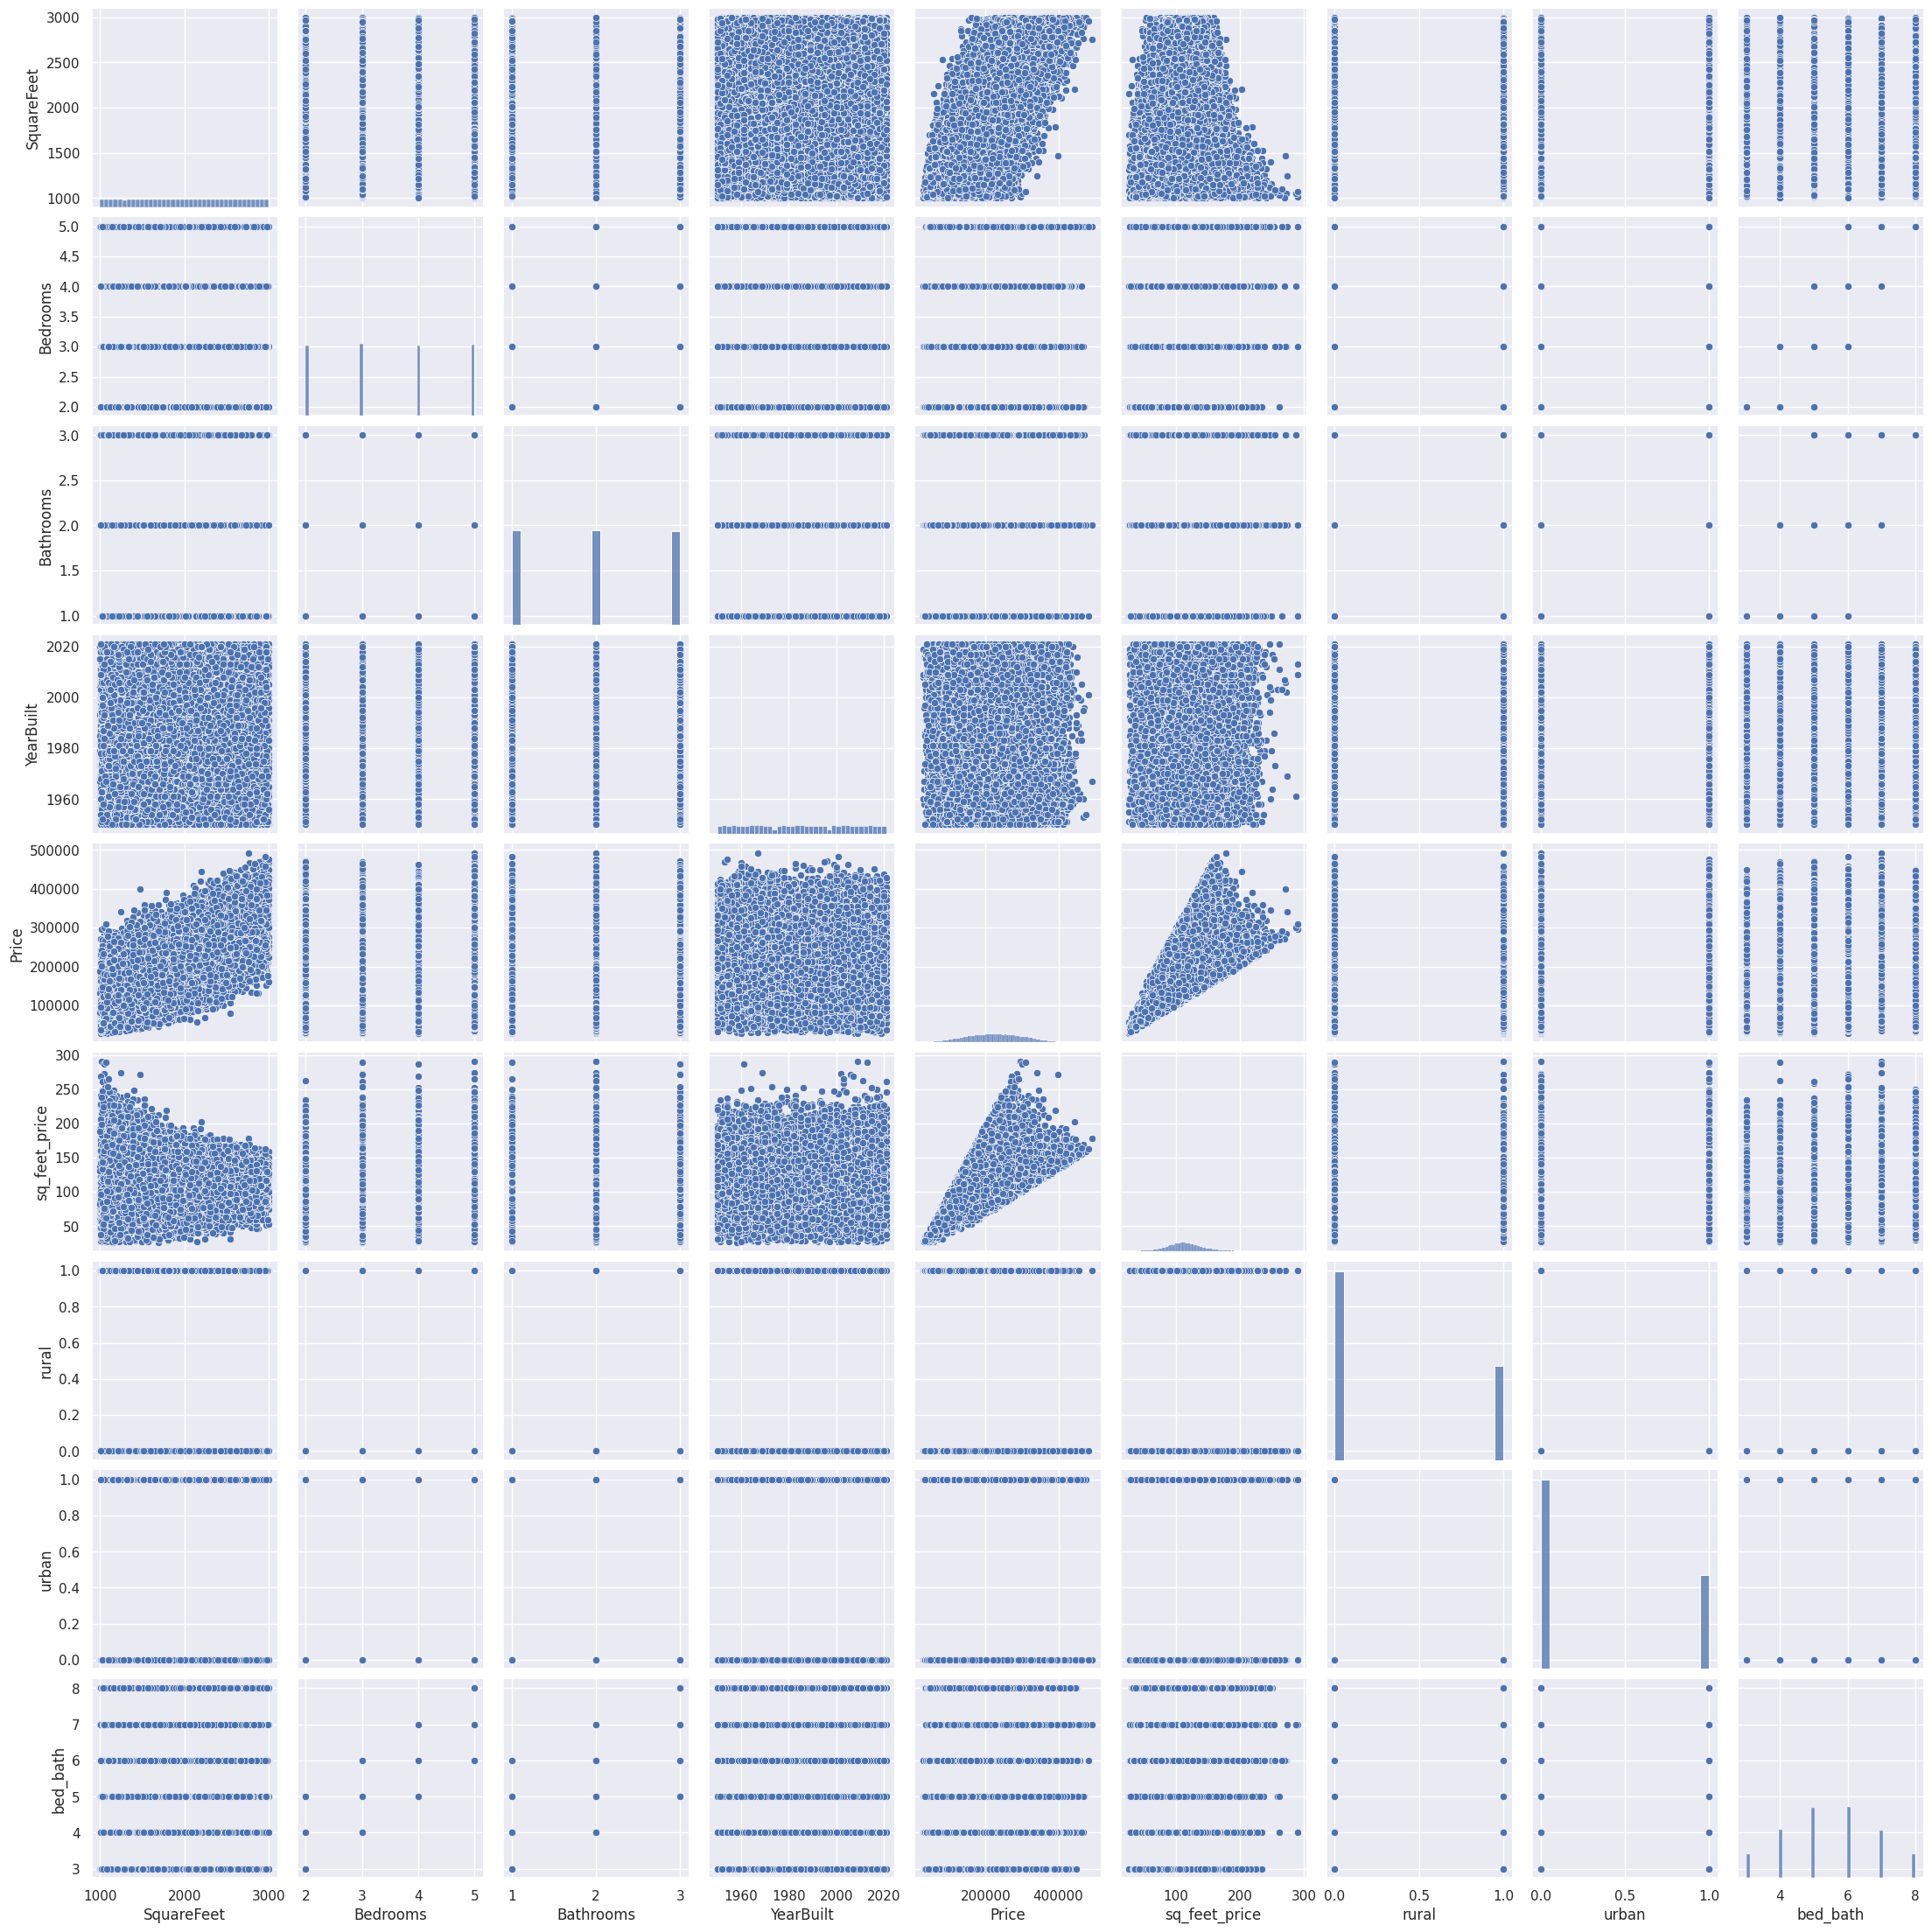

In [0]:
del df_py
df_py = df.toPandas() 

cols = df_py.columns.tolist()
sns.set()
sns.pairplot(df_py[cols], size = 2.5)
plt.show();

/root/.ipykernel/2781/command-640714396312897-3741489623:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df_py.corr()


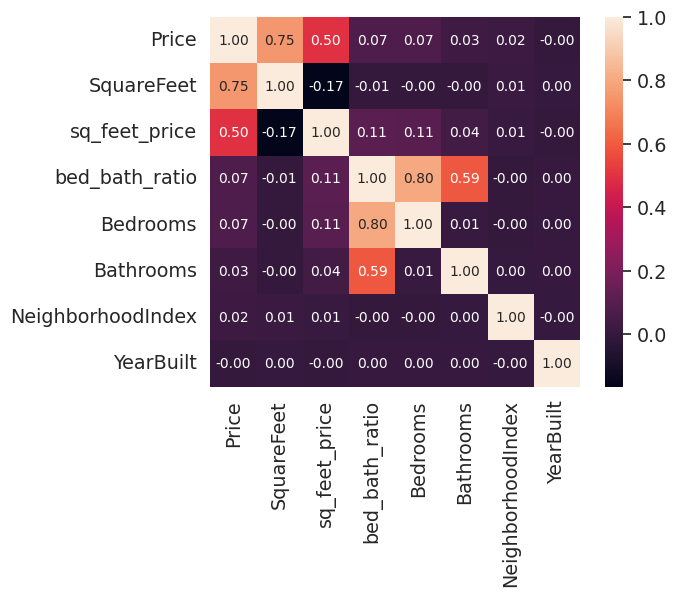

In [0]:
k = 10 #number of variables for heatmap
corrmat = df_py.corr()

cols = corrmat.nlargest(k, 'Price')['Price'].index
cm = np.corrcoef(df_py[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

/root/.ipykernel/2781/command-640714396312893-771298825:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_py[variable], fit=norm);


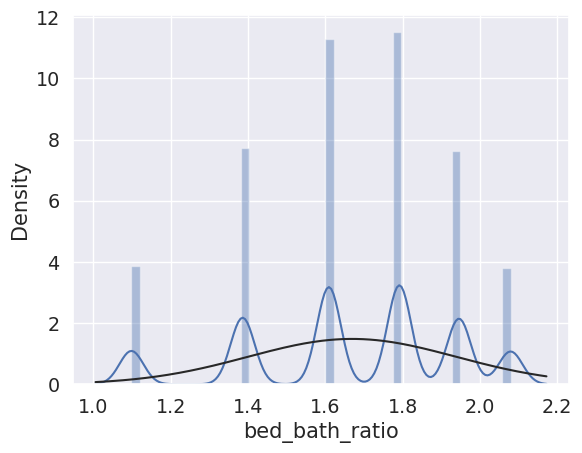

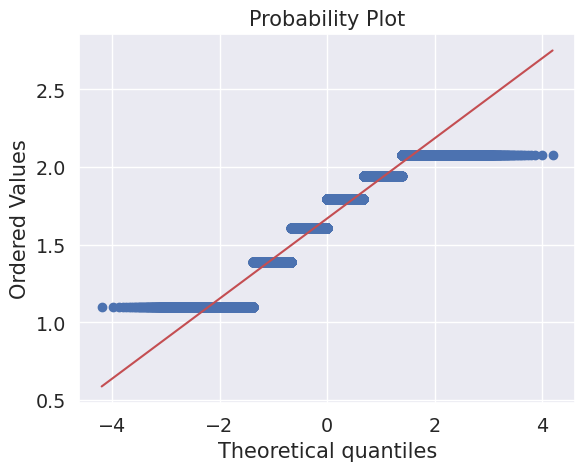

In [0]:
variable = 'bed_bath'
# ft_normality = df.select(variable).toPandas()
sns.distplot(df_py[variable], fit=norm);
fig = plt.figure()
res = stats.probplot(df_py[variable], plot=plt)

In [0]:
# Prepare features and labels
feature_columns = [col for col in df.columns if col not in ["Price", "Neighborhood", "sq_feet_price", 'Bedrooms', 'Bathrooms']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

data = assembler.transform(df).select("features", "Price")

# Split data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42) 

In [0]:
# Define the model
rf = RandomForestRegressor(featuresCol="features", labelCol="Price", maxDepth=5, numTrees=50)

# Create a pipeline
pipeline = Pipeline(stages=[rf])

# Train the model within an MLflow experiment
with mlflow.start_run():
    # Log a custom parameter for the data treatment change
    mlflow.log_param("data_treatment", "feature engineering: bed_bath & on-hot-encoding")

    # Fit the model
    model = pipeline.fit(train_data)

    # Predict on test data
    predictions = model.transform(test_data)

    # Evaluate RMSE
    evaluator_rmse = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="rmse")
    rmse = evaluator_rmse.evaluate(predictions)

    # Evaluate R²
    evaluator_r2 = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="r2")
    r2 = evaluator_r2.evaluate(predictions)

    # Evaluate MSE
    evaluator_mse = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="mse")
    mse = evaluator_mse.evaluate(predictions)

    # Log metrics and model
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mse", mse)

    # Log the trained model
    mlflow.spark.log_model(model, "random_forest_model")

    # Print out the evaluation metrics
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R²): {r2}")
    print(f"Mean Squared Error (MSE): {mse}")

## Model evaluation & residual analysis

In [0]:
predictions = predictions.withColumn("residual", col("Price")-col("prediction"))


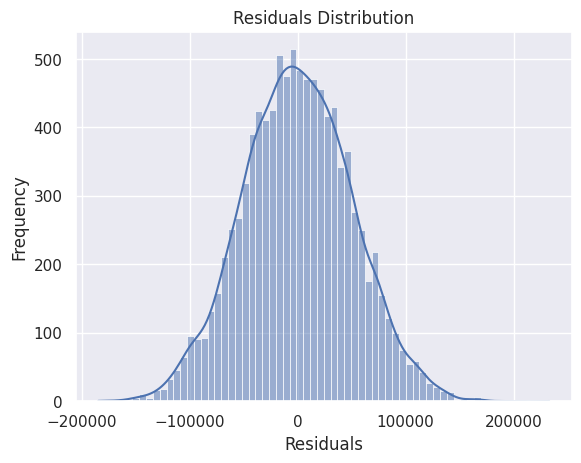

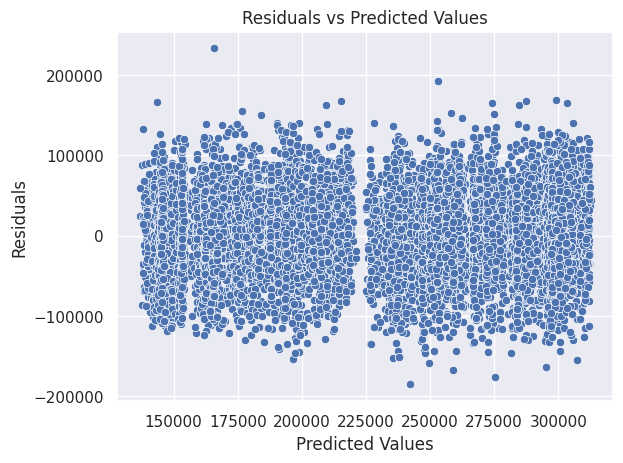

In [0]:
residuals_pd = predictions.select("residual").toPandas()

# Plot histogram of residuals
sns.histplot(residuals_pd["residual"], kde=True)  # KDE can be added for smoother visualization
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Plot residuals vs predicted values to check for patterns
predictions_pd = predictions.select("prediction").toPandas()
sns.scatterplot(x=predictions_pd["prediction"], y=residuals_pd["residual"])
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()